# <center> 🎤 Projet Final SER : Reconnaissance des Émotions avec EmoDB & RAVDESS </center>

---
## 🧠 **Reconnaissance des Émotions Vocales (SER)**
### Combinaison des jeux de données **EmoDB** et **RAVDESS** pour une analyse émotionnelle robuste

🎯 **Objectif :** Développer un système de **Reconnaissance des Émotions Vocales (SER)** en tirant parti de deux jeux de données puissants afin d’améliorer la classification des émotions à partir des signaux audio.


---

## 🌟 **Aperçu du Projet**
Ce projet intègre deux jeux de données largement reconnus pour la reconnaissance des émotions vocales :

- 🎙 **EmoDB** : Base de données berlinoise de parole émotionnelle, contenant des échantillons de voix en allemand étiquetés selon différentes émotions.
- 🎼 **RAVDESS** : Base de données audio-visuelle de Ryerson sur la parole et le chant émotionnels, composée d’enregistrements en anglais nord-américain.

En combinant ces jeux de données, notre objectif est d’améliorer les performances du modèle, en assurant une meilleure généralisation sur différents échantillons vocaux.


---
## 📊 **Comparaison des Étiquettes d’Émotions**

| Jeu de données | Étiquettes d’émotions                                  |
|----------------|--------------------------------------------------------|
| **EmoDB**      | Neutre, Ennui, Joie, Tristesse, Colère, Peur, Dégoût   |
| **RAVDESS**    | Neutre, Calme, Joie, Tristesse, Colère, Peur, Dégoût, Surprise |

### 🔹 **Correspondance Détaillée des Émotions :**
#### 📌 **Étiquettes d’Émotions de EmoDB :**
- 😠 **Colère**
- 😴 **Ennui**
- 🤢 **Dégoût**
- 😨 **Peur**
- 😃 **Joie**
- 😢 **Tristesse**
- 😐 **Neutre**

#### 📌 **Étiquettes d’Émotions de RAVDESS :**
- 😐 **Neutre** (01)
- 😌 **Calme** (02)
- 😃 **Joie** (03)
- 😢 **Tristesse** (04)
- 😠 **Colère** (05)
- 😨 **Peur** (06)
- 🤢 **Dégoût** (07)
- 😲 **Surprise** (08)


In [ ]:
!pip install --q librosa
!pip install --q mealpy

import pandas as pd
import numpy as np

import os
import sys
import tensorflow as tf
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, BatchNormalization, Dropout, Bidirectional, LSTM, Dense, Attention, Add, Flatten

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.9/104.9 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.3/386.3 kB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 103.4 MB/s eta 0:00:00


#  <center> 🇩🇪 EmoDB </center>

Mounted at /content/drive
Nombre de fichiers trouvés: 535

Détail par émotion:
neutral: 79
disgust: 46
fear: 69
sadness: 62
happiness: 71
anger: 127
boredom: 81


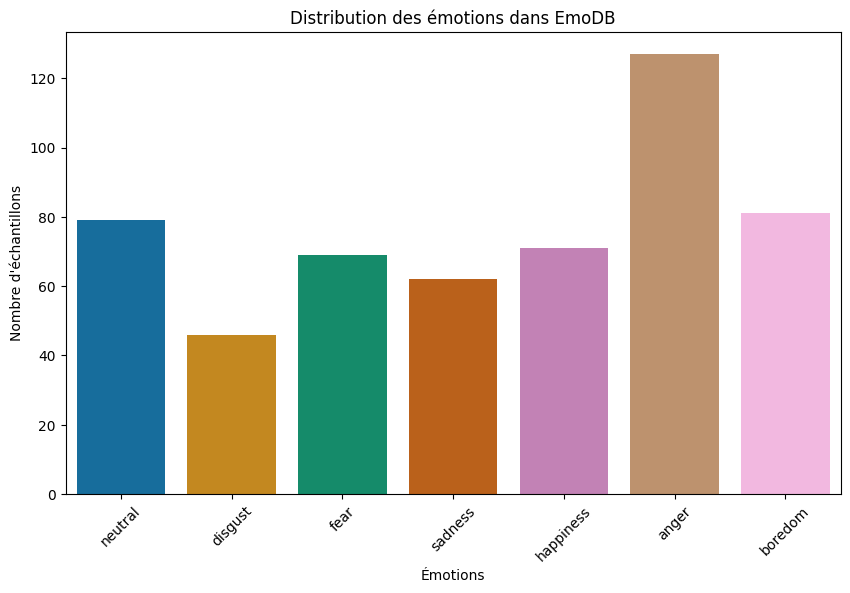

In [ ]:
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Montez Google Drive
from google.colab import drive
drive.mount('/content/drive')


# Original path: emodb_path = "/content/drive/My Drive/data/EmoDB/*.wav"
emodb_path = "/content/drive/My Drive/data/EmoDB/wav/*.wav"

# Mapping des émotions
emotion_map = {
    'W': 'anger',
    'L': 'boredom',
    'E': 'disgust',
    'A': 'fear',
    'F': 'happiness',
    'T': 'sadness',
    'N': 'neutral'
}

# Extraction des émotions avec vérification
filenames = glob.glob(emodb_path)
print(f"Nombre de fichiers trouvés: {len(filenames)}")

emotions = []
for f in filenames:
    basename = os.path.basename(f)
    if len(basename) >= 6:  # Vérifie que le nom est assez long
        emotion_code = basename[5]
        if emotion_code in emotion_map:
            emotions.append(emotion_map[emotion_code])
        else:
            print(f"Avertissement: Code émotion inconnu '{emotion_code}' dans {basename}")
    else:
        print(f"Avertissement: Nom de fichier trop court: {basename}")

if not emotions:
    raise ValueError("Aucune émotion valide trouvée. Vérifiez vos fichiers.")

# Comptage et affichage
emotion_counts = Counter(emotions)
emotion_order = ['neutral', 'disgust', 'fear', 'sadness', 'happiness', 'anger', 'boredom']
counts = [emotion_counts.get(e, 0) for e in emotion_order]

print("\nDétail par émotion:")
for emotion, count in zip(emotion_order, counts):
    print(f"{emotion}: {count}")

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=emotion_order, y=counts, hue=emotion_order, palette="colorblind", legend=False)
plt.xticks(rotation=45)
plt.xlabel("Émotions")00
plt.ylabel("Nombre d'échantillons")
plt.title("Distribution des émotions dans EmoDB")
plt.show()

In [ ]:
Emo_df = pd.DataFrame({
    'filenames': filenames,
    'emotions': emotions
})
Emo_df.head()

filenames   emotions
0  /content/drive/My Drive/data/EmoDB/wav/03a01Fa...  happiness
1  /content/drive/My Drive/data/EmoDB/wav/03a01Nc...    neutral
2  /content/drive/My Drive/data/EmoDB/wav/03a05Fc...  happiness
3  /content/drive/My Drive/data/EmoDB/wav/03a02Ta...    sadness
4  /content/drive/My Drive/data/EmoDB/wav/03a05Wb...      anger

# <center> 🇺🇸 RAVDESS </center>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Emotion Counts:
neutral: 96
calm: 192
happy: 192
sad: 192
angry: 192
fearful: 192
disgust: 192
surprised: 192


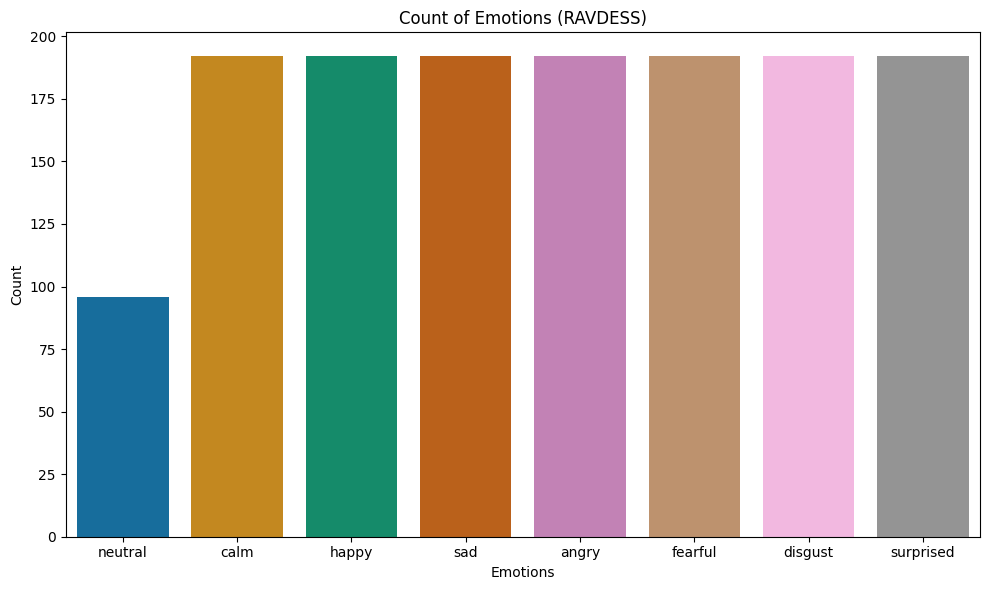

In [ ]:
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Montez Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Chemin correct vers les fichiers audio

ravdess_path =  "/content/drive/My Drive/data/RAVDESS/**/*.wav"
filenames = glob.glob(ravdess_path, recursive=True)  # Updated path. Please verify if this is the correct path to your audio files.


# Mapping RAVDESS numeric encoding t#  <center> 🇩🇪 EmoDB </center>o emotions
emotion_map = {
    '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fearful',
    '07': 'disgust',
    '08': 'surprised'
}

# Extract emotion labels from filenames
filenames = glob.glob(ravdess_path, recursive=True)
emotions = [emotion_map[os.path.basename(f).split('-')[2]] for f in filenames if os.path.basename(f).split('-')[2] in emotion_map]

# Count occurrences of each emotion
emotion_counts = Counter(emotions)

# Sort emotions by predefined order
emotion_order = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']
counts = [emotion_counts[e] for e in emotion_order if e in emotion_counts]

# Print the count of each emotion
print("Emotion Counts:")
for emotion in emotion_order:
    count = emotion_counts.get(emotion, 0)  # Get the count or default to 0 if emotion is not found
    print(f"{emotion}: {count}")

# Plot the emotion distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=emotion_order, y=counts, hue=emotion_order, palette="colorblind", legend=False)

plt.xlabel("Emotions")
plt.ylabel("Count")
plt.title("Count of Emotions (RAVDESS)")  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()

In [ ]:
Ravdess_df = pd.DataFrame({
    'filenames': filenames,
    'emotions': emotions
})
Ravdess_df.head()

filenames emotions
0  /content/drive/My Drive/data/RAVDESS/Actor_22/...     calm
1  /content/drive/My Drive/data/RAVDESS/Actor_22/...  neutral
2  /content/drive/My Drive/data/RAVDESS/Actor_22/...    happy
3  /content/drive/My Drive/data/RAVDESS/Actor_22/...    happy
4  /content/drive/My Drive/data/RAVDESS/Actor_22/...     calm

# <center> 🧩 Combiner 2 Jeux de Données </center>

---

## <center> **Création d’un Jeu de Données Unifié pour la Reconnaissance des Émotions** </center>

Dans cette section, nous allons fusionner deux jeux de données émotionnels majeurs :  
- **RAVDESS** (Base de données audio-visuelle de Ryerson sur la parole et le chant émotionnels)  
- **EmoDB** (Base de données berlinoise de parole émotionnelle)

En combinant ces jeux de données, notre objectif est de créer un ensemble de données complet et diversifié afin d’améliorer les performances de notre modèle de reconnaissance des émotions.

---

### <center> C’est parti ! </center>


In [ ]:
data_path = pd.concat([Ravdess_df,Emo_df], axis = 0)
data_path.to_csv("data_path.csv",index=False)

data_path.head()

filenames emotions
0  /content/drive/My Drive/data/RAVDESS/Actor_22/...     calm
1  /content/drive/My Drive/data/RAVDESS/Actor_22/...  neutral
2  /content/drive/My Drive/data/RAVDESS/Actor_22/...    happy
3  /content/drive/My Drive/data/RAVDESS/Actor_22/...    happy
4  /content/drive/My Drive/data/RAVDESS/Actor_22/...     calm

In [ ]:
data_path.reset_index(drop=True)

filenames   emotions
0     /content/drive/My Drive/data/RAVDESS/Actor_22/...       calm
1     /content/drive/My Drive/data/RAVDESS/Actor_22/...    neutral
2     /content/drive/My Drive/data/RAVDESS/Actor_22/...      happy
3     /content/drive/My Drive/data/RAVDESS/Actor_22/...      happy
4     /content/drive/My Drive/data/RAVDESS/Actor_22/...       calm
...                                                 ...        ...
1970  /content/drive/My Drive/data/EmoDB/wav/16b10Eb...    disgust
1971  /content/drive/My Drive/data/EmoDB/wav/16b10Fb...  happiness
1972  /content/drive/My Drive/data/EmoDB/wav/16b10Tb...    sadness
1973  /content/drive/My Drive/data/EmoDB/wav/16b10Lb...    boredom
1974  /content/drive/My Drive/data/EmoDB/wav/16b09Wb...      anger

[1975 rows x 2 columns]

# <center> 🗑️ Supprimer Certaines Catégories pour Aligner les Étiquettes </center>

---

## <center> **Alignement des Étiquettes d’Émotions entre les Jeux de Données** </center>

Pour garantir la cohérence entre les jeux de données **RAVDESS** et **EmoDB**, nous allons simplifier les catégories d’émotions en supprimant les étiquettes qui ne sont pas communes aux deux jeux de données.

Cette étape est essentielle pour créer un **ensemble unifié d’étiquettes d’émotions**, ce qui permettra d’améliorer la fiabilité et la précision de notre modèle de reconnaissance des émotions.

---

### <center> Passons à l’alignement des étiquettes ! </center>


In [ ]:
data_path = data_path[data_path["emotions"].str.contains("calm") == False]
data_path = data_path[data_path["emotions"].str.contains("boredom") == False]
data_path = data_path[data_path["emotions"].str.contains("ps") == False]
data_path = data_path[data_path["emotions"].str.contains("surprise") == False]
data_path['emotions'] = data_path['emotions'].replace({
    'anger': 'angry',
    'happiness': 'happy',
    'sadness': 'sad',
    'fearful' : 'fear'
})
data_path['emotions'].unique()

array(['neutral', 'happy', 'angry', 'sad', 'disgust', 'fear'],
      dtype=object)

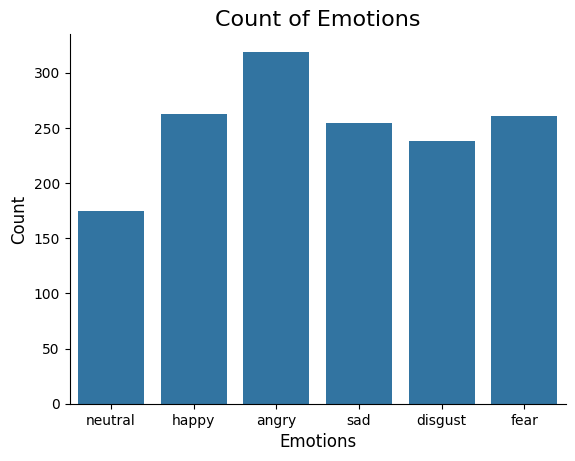

Counter({'neutral': 175,
         'happy': 263,
         'angry': 319,
         'sad': 254,
         'disgust': 238,
         'fear': 261})

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import collections


# Set the title and labels
plt.title('Count of Emotions', size=16)

# Plot the count of emotions
sns.countplot(x=data_path['emotions'])  # Use x= to specify the column

# Add axis labels
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)

# Remove unnecessary spines
sns.despine(top=True, right=True, left=False, bottom=False)

# Display the plot
plt.show()
collections.Counter(data_path['emotions'])

# <center> 📊 Visualisation des Caractéristiques Audio pour l’Analyse des Émotions </center>

---

## <center> **Explorer les Caractéristiques Audio en Fonction des Émotions** </center>

Dans cette section, nous allons explorer les caractéristiques audio de notre jeu de données afin de mieux comprendre comment les différentes émotions se manifestent dans les signaux audio. En visualisant les formes d’onde, les spectrogrammes et les Coefficients Cepstraux en Fréquence Mel (MFCC), nous cherchons à identifier les spécificités propres à chaque émotion.

---

### <center> **Pourquoi Visualiser les Caractéristiques Audio ?** </center>

- **Forme d’onde** : Fournit une vue temporelle du signal audio, montrant les variations d’amplitude dans le temps.
- **Spectrogramme** : Offre une perspective fréquentielle, révélant comment l’intensité des différentes fréquences évolue dans le temps.
- **MFCCs** : Capturent l’enveloppe spectrale du signal, imitant la perception humaine et constituant une représentation compacte pour les modèles d’apprentissage automatique.

Ces visualisations nous permettent de :
- Identifier les motifs spécifiques à chaque émotion.
- Vérifier la qualité des données.
- Acquérir une intuition sur la manière dont les caractéristiques audio peuvent être exploitées pour reconnaître les émotions.

---

### <center> **Flux de Travail de Visualisation** </center>

Pour chaque émotion dans le jeu de données, nous réalisons les étapes suivantes :

1. **Sélectionner un Échantillon Audio** :
   - Filtrer le jeu de données selon les émotions cibles.
   - Charger le fichier audio correspondant à l’aide de `librosa`.

2. **Générer la Forme d’Onde** :
   - Tracer la forme d’onde pour observer les variations d’amplitude au fil du temps.
   - Exemple : Une forme d’onde régulière avec peu de fluctuations peut indiquer une émotion calme ou neutre.

3. **Générer le Spectrogramme** :
   - Calculer la Transformée de Fourier à Court Terme (STFT) pour analyser le contenu fréquentiel de l’audio.
   - Visualiser le spectrogramme pour identifier les fréquences dominantes et leur évolution temporelle.
   - Exemple : Les sons vocalisés apparaissent comme des bandes verticales lumineuses, tandis que les silences ou sons non vocalisés apparaissent comme des zones sombres.

4. **Générer les MFCCs** :
   - Extraire les MFCCs pour représenter l’enveloppe spectrale de l’audio.
   - Visualiser les MFCCs pour observer la variation des coefficients dans le temps.
   - Exemple : Les MFCCs offrent une représentation compacte des caractéristiques les plus pertinentes pour la classification des émotions.

5. **Écouter l’Audio** :
   - Utiliser la fonction `Audio` pour écouter l’échantillon sélectionné et mettre en relation le son avec sa représentation visuelle.


In [ ]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveform for audio with emotion {}'.format(e), size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    # stft performs Fourier transform.
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with emotion {}'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar()
def create_mfcc(data, sr, e):
    mfcc = librosa.feature.mfcc(y=data, sr=sr, n_mfcc=13)
    plt.figure(figsize=(12, 3))
    plt.title('Mel-frequency cepstral coefficient for audio with emotion {}'.format(e), size=15)
    librosa.display.specshow(mfcc, x_axis='time')
    plt.ylabel('MFCC')
    plt.colorbar()

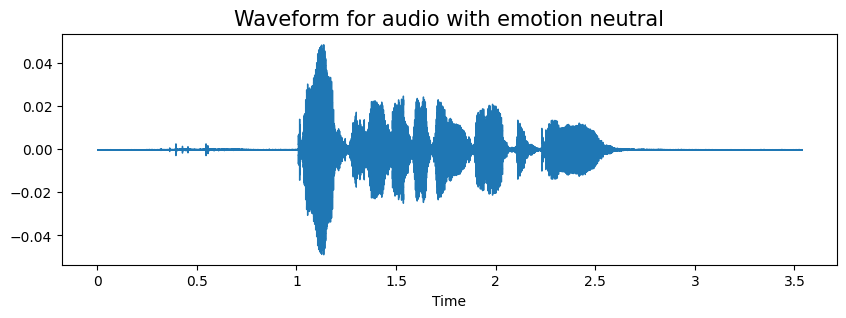

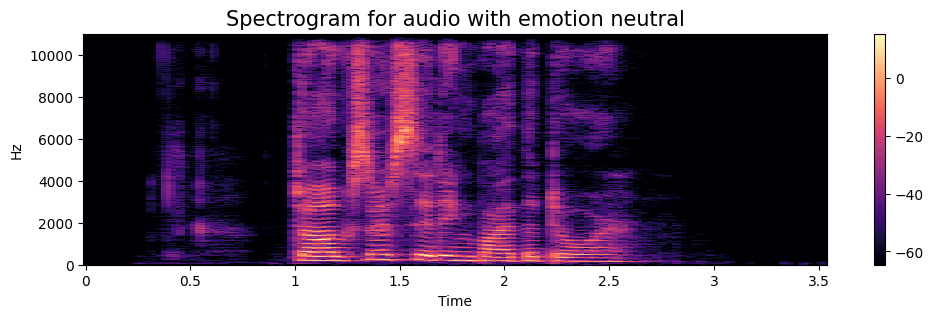

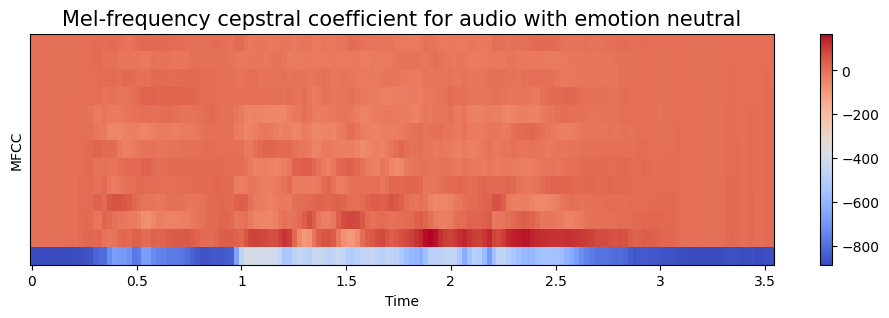

In [ ]:
emotion = 'neutral'
path = np.array(data_path.filenames[data_path.emotions == emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
create_mfcc(data, sampling_rate, emotion)
Audio(path)

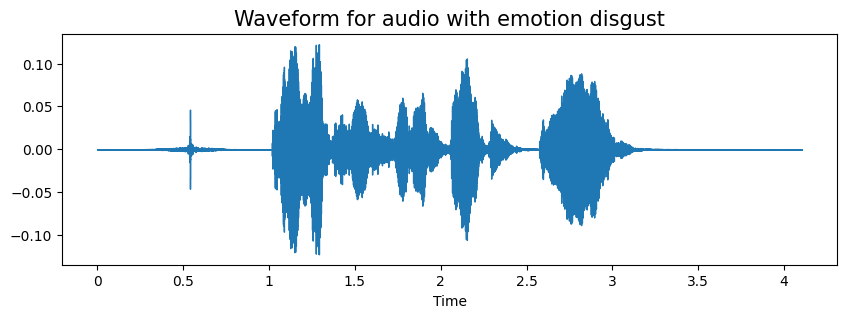

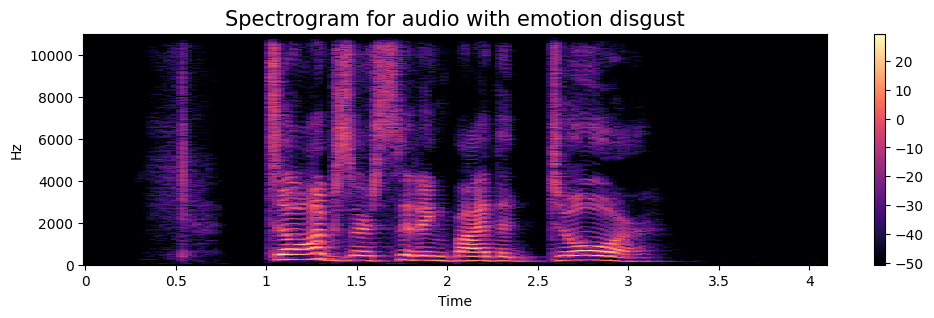

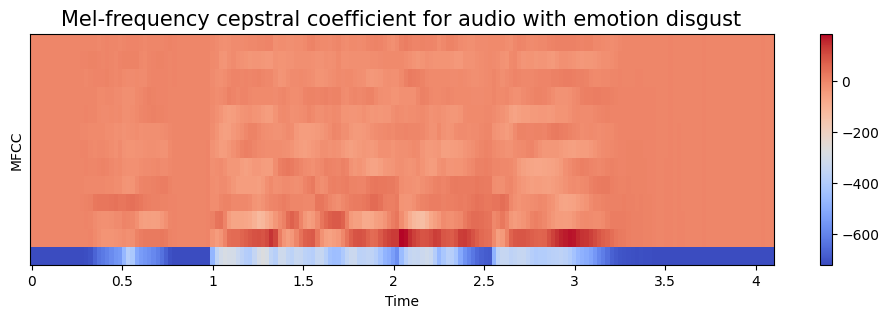

In [ ]:
emotion = 'disgust'
path = np.array(data_path.filenames[data_path.emotions == emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
create_mfcc(data, sampling_rate, emotion)
Audio(path)

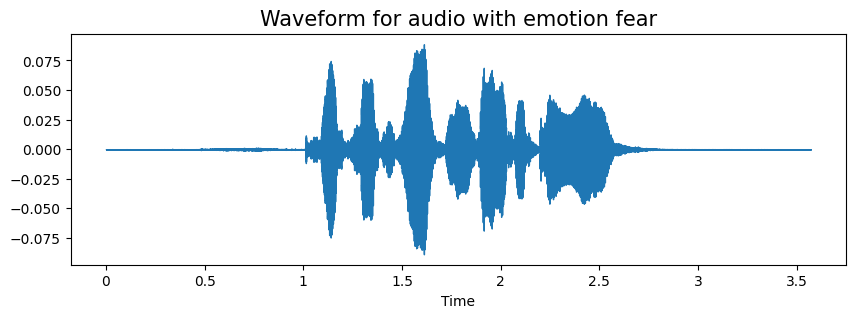

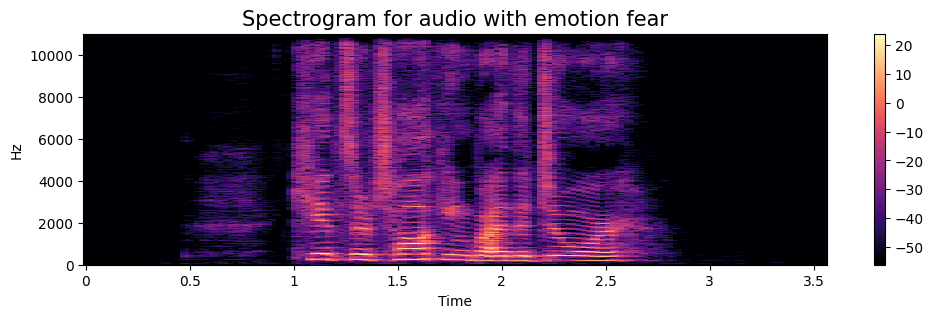

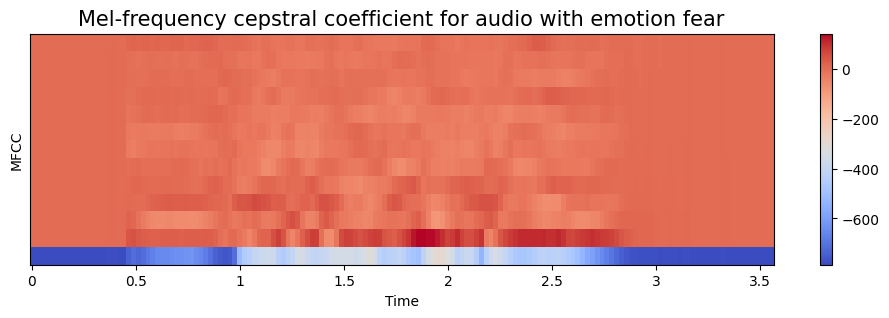

In [ ]:
emotion = 'fear'
path = np.array(data_path.filenames[data_path.emotions == emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
create_mfcc(data, sampling_rate, emotion)
Audio(path)

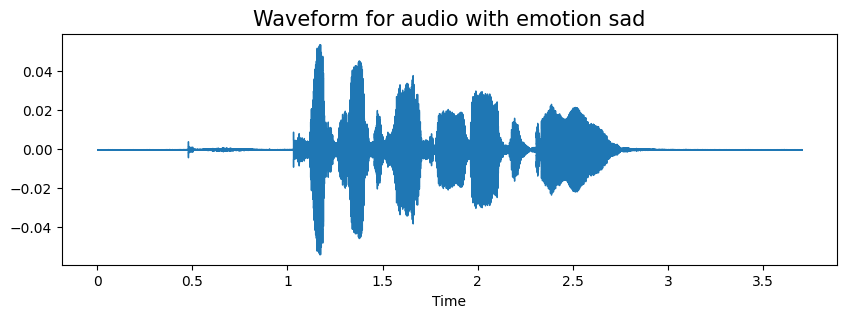

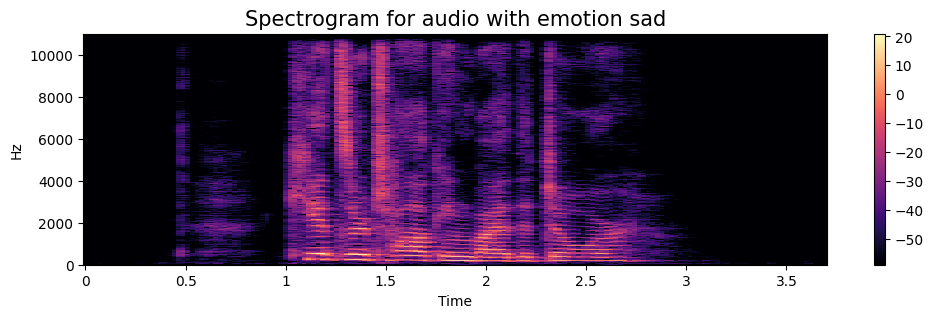

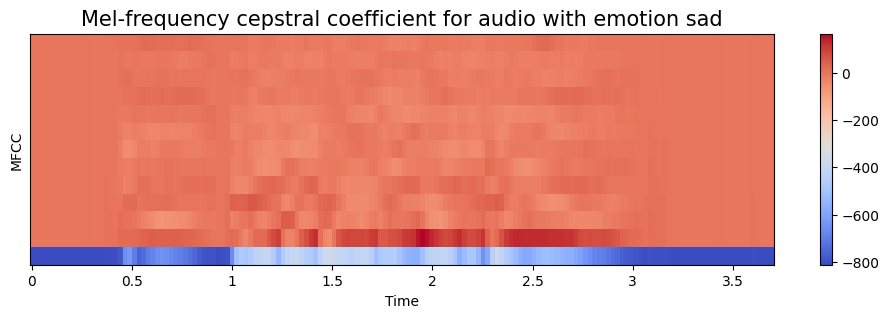

In [ ]:
emotion = 'sad'
path = np.array(data_path.filenames[data_path.emotions == emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
create_mfcc(data, sampling_rate, emotion)
Audio(path)

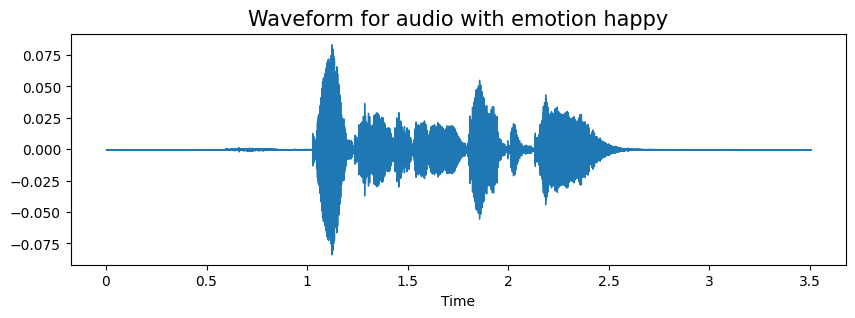

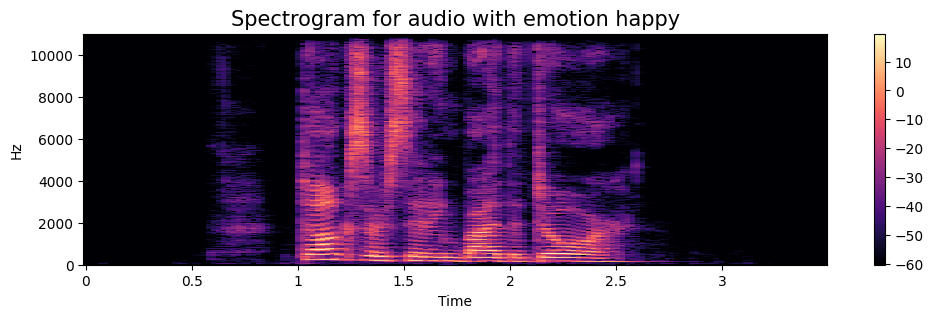

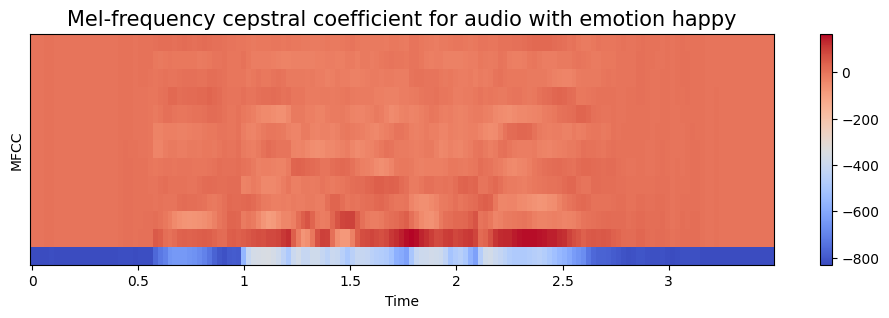

In [ ]:
emotion = 'happy'
path = np.array(data_path.filenames[data_path.emotions == emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
create_mfcc(data, sampling_rate, emotion)
Audio(path)

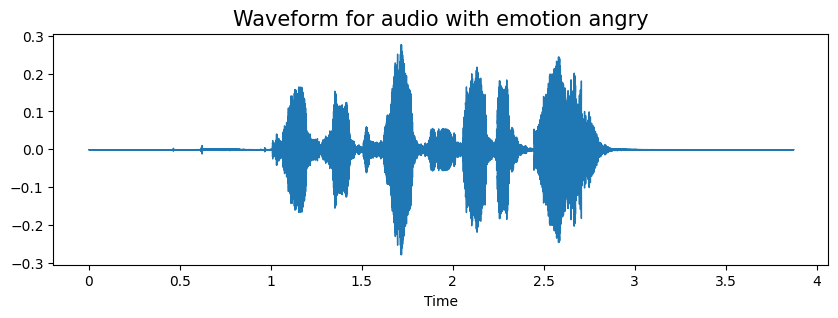

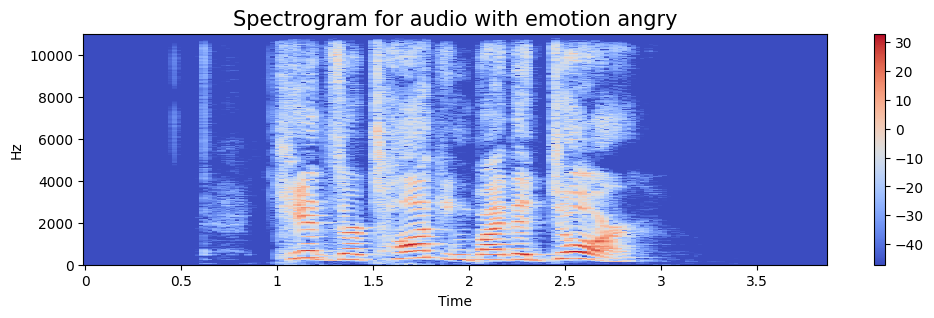

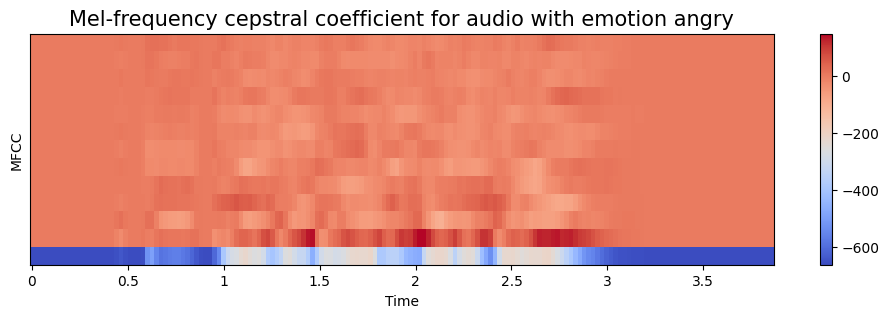

In [ ]:
emotion = 'angry'
path = np.array(data_path.filenames[data_path.emotions == emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
create_mfcc(data, sampling_rate, emotion)
Audio(path)

# <center> 🎵 Augmentations des Données : Enrichir la Diversité Audio </center>

---

## <center> **Exploration des Techniques d’Augmentation** </center>

Dans cette section, nous explorons différentes techniques d’augmentation de données afin d’enrichir la diversité de notre jeu de données audio. Ces augmentations simulent des variations réelles des signaux audio, rendant notre modèle de reconnaissance des émotions plus robuste et généralisable.

Chaque augmentation est visualisée et expliquée ci-dessous :

---

### <center> **1. Son Normal 🎤** </center>

- Représente le signal audio original, non modifié.
- Aucune transformation n’est appliquée.
- Sert de référence pour comparer avec les versions augmentées.

#### **Caractéristiques Clés** :
- Forme d’onde propre et non altérée.
- Reflète les caractéristiques naturelles de l’audio.

---

### <center> **2. Injection de Bruit 🔊⚡** </center>

- Ajoute un bruit de fond aléatoire au signal audio.
- Simule des scénarios réels avec du bruit ambiant (ex. : circulation, brouhaha de foule).

#### **Pourquoi l’utiliser ?**
- Aide le modèle à se généraliser à des environnements bruyants.
- Améliore la robustesse face à des entrées audio imparfaites.

---

### <center> **3. Étirement Temporel ⏩⏪** </center>

- Allonge ou compresse le signal audio sans modifier la hauteur.
- Simule des variations dans la vitesse de parole (ex. : discours plus rapide ou plus lent).

#### **Pourquoi l’utiliser ?**
- Capture les variations temporelles dans les schémas de parole.
- Utile pour gérer les locuteurs parlant à différentes vitesses.

---

### <center> **4. Déplacement de Hauteur Tonale 🎶↕️** </center>

- Modifie la hauteur du signal audio vers le haut ou vers le bas d’un certain nombre de demi-tons.
- Simule des variations dans le ton de la voix (ex. : voix plus aiguë ou plus grave).

#### **Pourquoi l’utiliser ?**
- Prend en compte les différences de genre, d’âge ou d’intensité émotionnelle des locuteurs.
- Améliore la capacité du modèle à reconnaître les émotions à travers des tons vocaux variés.


In [ ]:
import numpy as np
import librosa
import matplotlib.pyplot as plt
from IPython.display import Audio

# Define augmentation functions
def noise(data, noise_rate=0.05):
    noise_amp = noise_rate * np.random.uniform() * np.amax(data)
    data = data + noise_amp * np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.9):
    return librosa.effects.time_stretch(data, rate=rate)

def pitch_shift(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=pitch_factor)

# Load an example audio file
path = np.array(data_path.filenames)[2]
data, sample_rate = librosa.load(path)

# Apply augmentations
x_stretched = stretch(data)
x_pitch_shifted = pitch_shift(data, sample_rate)

## <center> **1. Normal Sound 🎤** </center>

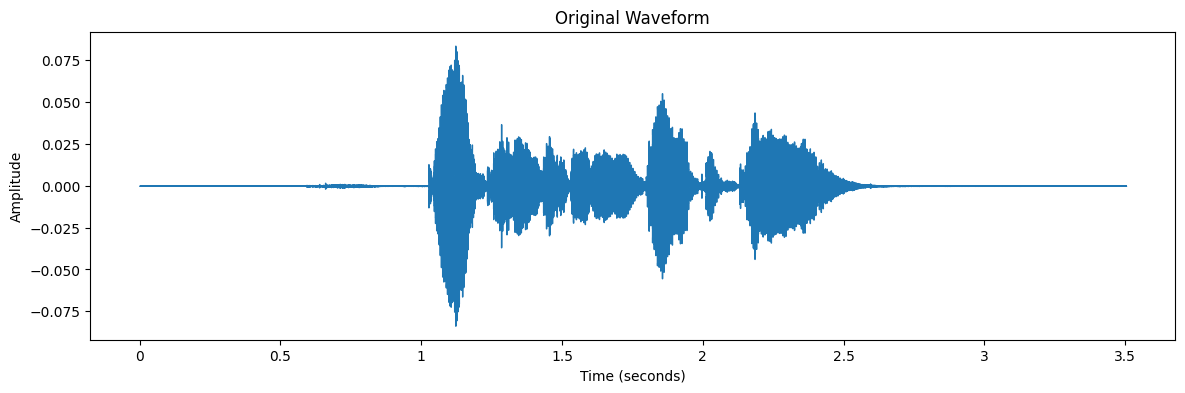

In [ ]:
# Plot the original waveform
plt.figure(figsize=(14, 4))
librosa.display.waveshow(y=data, sr=sample_rate)
plt.title("Original Waveform")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.show()

# Play the original audio
Audio(data, rate=sample_rate)

## <center> **2. Noise Injection 🔊⚡** </center>

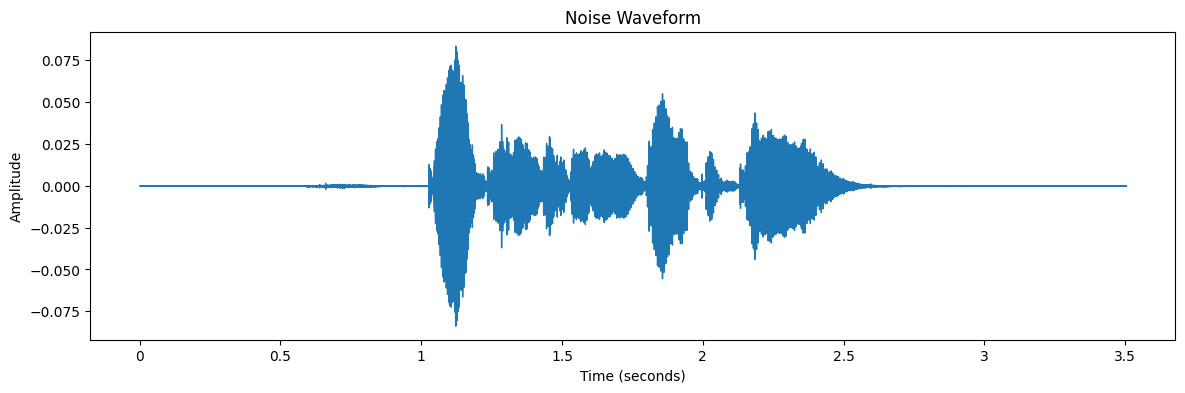

In [ ]:
x = noise(data)

# Load the audio file
data, sample_rate = librosa.load(path)

# Plot the waveform using waveshow
plt.figure(figsize=(14, 4))
librosa.display.waveshow(y=data, sr=sample_rate)
plt.title("Noise Waveform")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.show()

Audio(x, rate=sample_rate)

## <center> **3. Time Stretching ⏩⏪** </center>

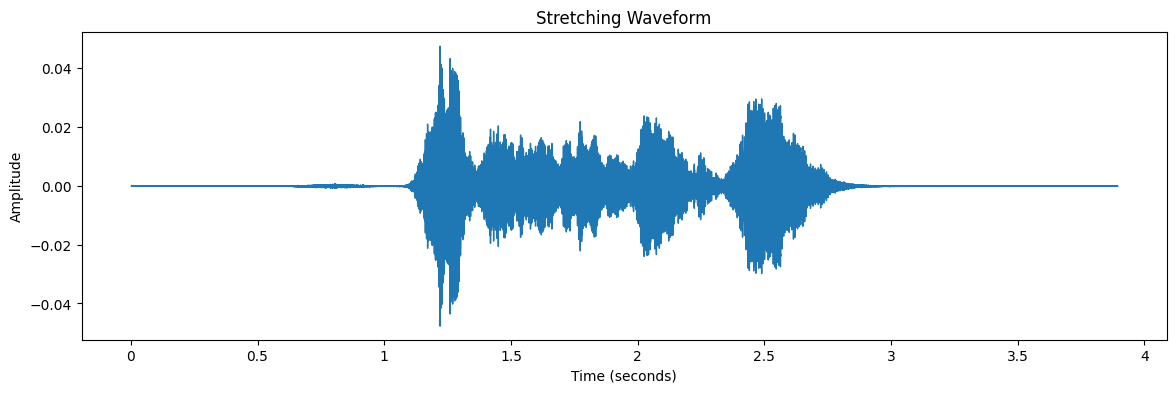

In [ ]:
x = stretch(data)

# Load the audio file
data, sample_rate = librosa.load(path)

# Plot the stretched waveform
plt.figure(figsize=(14, 4))
librosa.display.waveshow(y=x_stretched, sr=sample_rate)
plt.title("Stretching Waveform")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.show()

Audio(x, rate=sample_rate)

## <center> **4. Pitch Shifting 🎶↕️** </center>

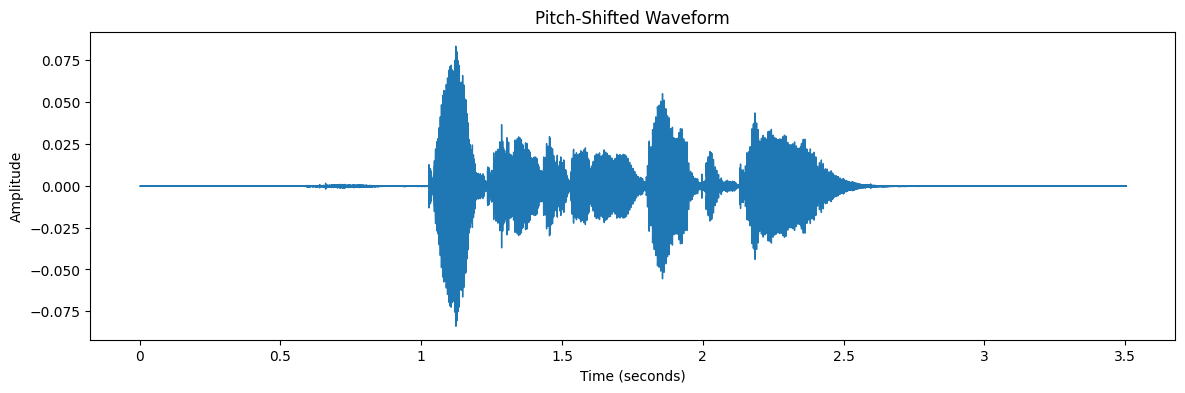

In [ ]:
x_pitch_shifted = pitch_shift(data, sample_rate)

# Load the audio file
data, sample_rate = librosa.load(path)

# Plot the waveform using waveshow
plt.figure(figsize=(14, 4))
librosa.display.waveshow(y=data, sr=sample_rate)
plt.title("Pitch-Shifted Waveform")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.show()

Audio(x_pitch_shifted, rate=sample_rate)

In [ ]:
FIXED_LENGTH = 5120  # Adjust this based on your dataset's typical audio length

# Zero Crossing Rate
def zcr(data, frame_length=2048, hop_length=512):
    zcr = librosa.feature.zero_crossing_rate(y=data, frame_length=frame_length, hop_length=hop_length)
    return np.squeeze(zcr)

# RMS Energy
def rmse(data, frame_length=2048, hop_length=512):
    rmse = librosa.feature.rms(y=data, frame_length=frame_length, hop_length=hop_length)
    return np.squeeze(rmse)

# MFCC
def mfcc(data, sr, frame_length=2048, hop_length=512, flatten: bool = True):
    mfcc_feature = librosa.feature.mfcc(y=data, sr=sr)
    return np.squeeze(mfcc_feature.T) if not flatten else np.ravel(mfcc_feature.T)

# Extract features and stack them into a one-dimensional array
def extract_features(data, sr, frame_length=2048, hop_length=512):
    # Fix the length of the audio signal
    data = librosa.util.fix_length(data, size=FIXED_LENGTH)

    # Extract features
    zcr_feature = zcr(data, frame_length, hop_length)
    rmse_feature = rmse(data, frame_length, hop_length)
    mfcc_feature = mfcc(data, sr, frame_length, hop_length)

    # Combine features into a single vector
    result = np.hstack((zcr_feature, rmse_feature, mfcc_feature))
    return result


In [ ]:
# Data augmentation function for the model
def get_features(path):
    # Load audio file
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)

    # Normal data
    res1 = extract_features(data, sample_rate)
    result = np.array(res1)

    # Noise data
    noise_data = noise(data)
    res2 = extract_features(noise_data, sample_rate)
    result = np.vstack((result, res2))

    # Stretched data
    stretched_data = stretch(data)
    res3 = extract_features(stretched_data, sample_rate)
    result = np.vstack((result, res3))

    # Pitch-shifted data
    pitched_data = pitch_shift(data, sample_rate)
    res4 = extract_features(pitched_data, sample_rate)
    result = np.vstack((result, res4))

    # Combined pitch + noise
    pitched_noise_data = noise(pitched_data)
    res5 = extract_features(pitched_noise_data, sample_rate)
    result = np.vstack((result, res5))

    return result

In [ ]:
X, Y = [], []
for path, emotion in zip(data_path.filenames, data_path.emotions):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        # Each data point will be added 4 times due to 4 augmentations (normal, noise, stretch, pitch-shift).
        Y.append(emotion)

# Extract the length of the feature matrix X and label array Y
len(X), len(Y), data_path.filenames.shape

(7550, 7550, (1510,))

In [ ]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)
print(Features.head(10))

Features = pd.read_csv('features.csv')
print(Features.shape)

          0         1         2         3         4         5         6  \
0  0.194336  0.281250  0.350098  0.306152  0.281738  0.267578  0.273926   
1  0.249023  0.374023  0.508789  0.517090  0.520508  0.524414  0.512207   
2  0.176758  0.263672  0.367188  0.369141  0.339355  0.311035  0.253906   
3  0.163086  0.253906  0.349609  0.337402  0.321777  0.281250  0.230469   
4  0.255859  0.375000  0.495117  0.490723  0.486816  0.485352  0.497559   
5  0.407715  0.568848  0.692383  0.586914  0.480957  0.395508  0.333496   
6  0.253906  0.369141  0.470215  0.435059  0.407227  0.366211  0.328613   
7  0.239258  0.367188  0.489746  0.492676  0.497559  0.500488  0.495117   
8  0.228027  0.345215  0.459473  0.459961  0.467285  0.479004  0.447266   
9  0.254395  0.385742  0.507324  0.508301  0.503906  0.485840  0.485352   

          7         8         9  ...       233        234        235  \
0  0.293945  0.359863  0.286621  ...  6.848424  14.303211  19.532574   
1  0.514648  0.505371  0.37695

In [ ]:
X = Features.iloc[:, :-1].values
Y = Features['labels'].values

# Encode labels for multi-class classification
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1, 1)).toarray()
encoder.categories_

[array(['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad'],
       dtype=object)]

# 80/10/10

In [ ]:
from sklearn.model_selection import train_test_split

# Split the data into 90% (training + validation) and 10% testing
x_train_val, x_test, y_train_val, y_test = train_test_split(
    X, Y, test_size=0.1, random_state=30, shuffle=True, stratify=Y
)

# Split the 90% portion into 80% training and 10% validation
x_train, x_val, y_train, y_val = train_test_split(
    x_train_val, y_train_val, test_size=0.1111, random_state=30, shuffle=True, stratify=y_train_val
)

# Check the shapes of the resulting datasets
print("Shapes:")
print("Training set:", x_train.shape, y_train.shape)
print("Validation set:", x_val.shape, y_val.shape)
print("Testing set:", x_test.shape, y_test.shape)

Shapes:
Training set: (6040, 242) (6040, 6)
Validation set: (755, 242) (755, 6)
Testing set: (755, 242) (755, 6)


In [ ]:
# Use MinMaxScaler for normalization
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)
x_test = scaler.transform(x_test)

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((6040, 242), (6040, 6), (755, 242), (755, 6))

# Model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, BatchNormalization, Dropout, LSTM, Dense

# Reshape the data to include the channel dimension
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)  # Shape: (5285, 242, 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)      # Shape: (1510, 242, 1)

# Define the model
model = Sequential()

# First Conv1D Block
model.add(Conv1D(1024, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(242, 1)))
model.add(MaxPooling1D(pool_size=2, strides=2, padding='same'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Second Conv1D Block
model.add(Conv1D(512, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2, strides=2, padding='same'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Third Conv1D Block
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2, strides=2, padding='same'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# LSTM Layers
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(128))
model.add(Dropout(0.3))

# Fully Connected Dense Layers
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))

# Output Layer (6 classes)
model.add(Dense(6, activation='softmax'))  # Assuming 6 emotion classes

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 242, 1024)      │         6,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 121, 1024)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 121, 1024)      │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 121, 1024)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 121, 512)       │     2,621,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 61, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 61, 512)        │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 61, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 61, 256)        │       655,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 31, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 31, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 31, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 31, 128)        │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 31, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 31, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 31, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,778,214 (14.41 MB)

 Trainable params: 3,774,630 (14.40 MB)

 Non-trainable params: 3,584 (14.00 KB)

In [ ]:
# Define callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)
# checkpoint = tf.keras.callbacks.ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max')

# Train the model
history = model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=50,
    batch_size=64
    # callbacks=[early_stopping, reduce_lr]
)

Epoch 1/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 349s 4s/step - accuracy: 0.2297 - loss: 1.7393 - val_accuracy: 0.1762 - val_loss: 1.8673
Epoch 2/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 337s 4s/step - accuracy: 0.3059 - loss: 1.6123 - val_accuracy: 0.1722 - val_loss: 1.9117
Epoch 3/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 372s 3s/step - accuracy: 0.3192 - loss: 1.5790 - val_accuracy: 0.1722 - val_loss: 2.0376
Epoch 4/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 382s 3s/step - accuracy: 0.3301 - loss: 1.5509 - val_accuracy: 0.1722 - val_loss: 2.0444
Epoch 5/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 381s 3s/step - accuracy: 0.3518 - loss: 1.5077 - val_accuracy: 0.1868 - val_loss: 1.9884
Epoch 6/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 336s 4s/step - accuracy: 0.3546 - loss: 1.5170 - val_accuracy: 0.2411 - val_loss: 1.8366
Epoch 7/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 383s 4s/step - accuracy: 0.3489 - loss: 1.4814 - val_accuracy: 0.2265 - val_loss: 2.0225
Epoch 8/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 372s 3s/step - accuracy: 0.3835 - loss: 1.4420 - val_accuracy: 0.3629 - v

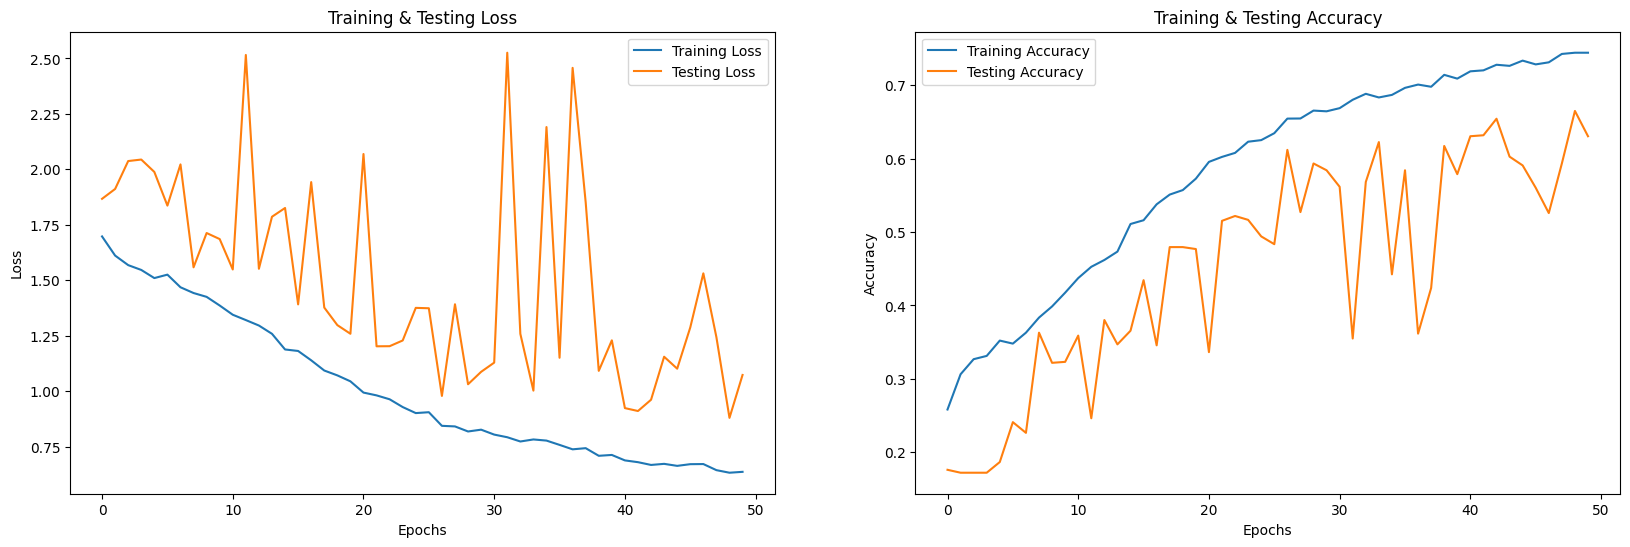

In [ ]:
# Dynamically generate the epochs array based on the training history
epochs = [i for i in range(len(history.history['loss']))]

# Create subplots
fig, ax = plt.subplots(1, 2)

# Extract metrics from the history object
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

# Set figure size
fig.set_size_inches(20, 6)

# Plot Training & Testing Loss
ax[0].plot(epochs, train_loss, label='Training Loss')
ax[0].plot(epochs, test_loss, label='Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")

# Plot Training & Testing Accuracy
ax[1].plot(epochs, train_acc, label='Training Accuracy')
ax[1].plot(epochs, test_acc, label='Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy")

# Show the plots
plt.show()

In [ ]:
results = model.evaluate(x_test, y_test, batch_size=128)
print("test loss, test acc:", results)

6/6 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.6298 - loss: 1.0518
test loss, test acc: [1.073042631149292, 0.6304636001586914]


In [ ]:
# Predict based on the test set
pred_test = model.predict(x_test)

y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

24/24 ━━━━━━━━━━━━━━━━━━━━ 12s 484ms/step


In [ ]:
pred_test=model.predict(x_test)

24/24 ━━━━━━━━━━━━━━━━━━━━ 12s 518ms/step


In [ ]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(20)

Predicted Labels Actual Labels
0               sad           sad
1           disgust         happy
2             happy         happy
3             angry         angry
4           disgust       disgust
5             happy         happy
6             angry         angry
7              fear         happy
8           neutral       neutral
9           disgust       disgust
10            happy         happy
11            angry         angry
12              sad          fear
13          neutral       neutral
14          disgust          fear
15          disgust         happy
16          disgust         happy
17             fear       disgust
18              sad           sad
19            angry          fear

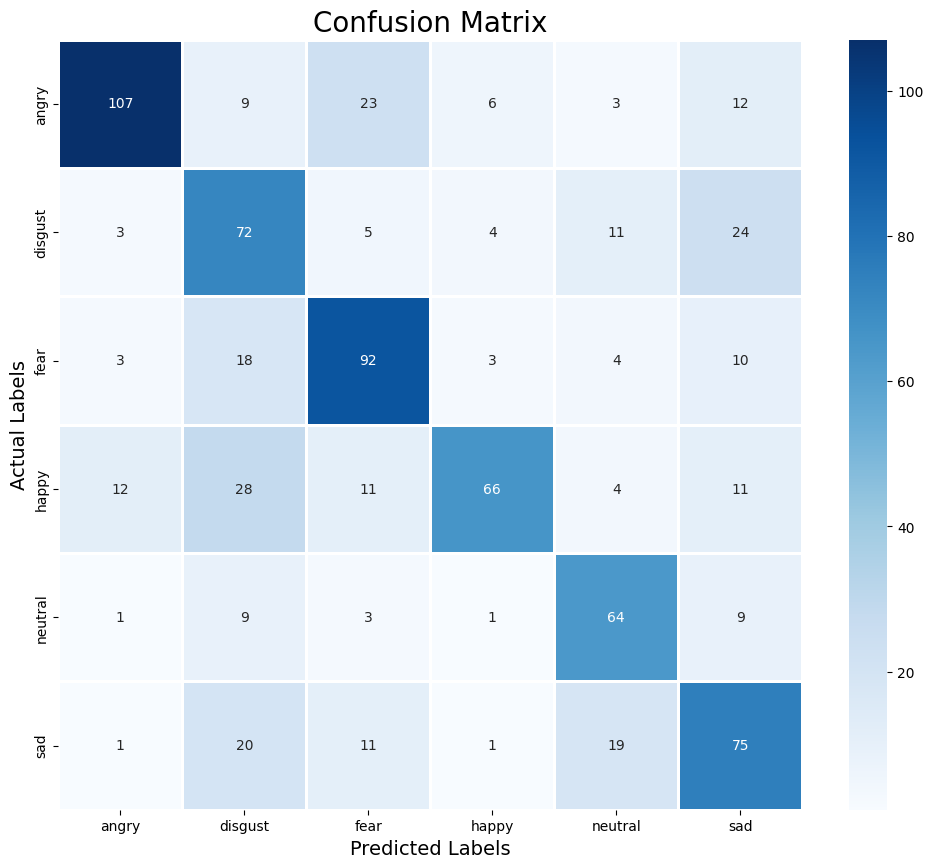

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

**Application d'un Autoencoder suivi d'un CNN sur les datasets RAVDESS et EmoDB**

**Étape 1: Préparation des données**

In [ ]:
import numpy as np
import librosa
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from google.colab import drive

# Paramètres constants pour toutes les extractions
MFCC_LEN = 40
DURATION = 3  # secondes
SR = 22050   # taux d'échantillonnage
N_TIMESTEPS = int(SR * DURATION / 512)  # Calculé une fois pour toutes

def extract_features(file_path):
    try:
        # Chargement du fichier audio avec la durée fixe
        audio, sr = librosa.load(file_path, sr=SR, duration=DURATION)

        # Extraction des MFCC
        mfccs = librosa.feature.mfcc(y=audio, sr=SR, n_mfcc=MFCC_LEN)

        # Normalisation
        mfccs = (mfccs - np.mean(mfccs)) / np.std(mfccs)

        # Padding/Truncating pour avoir une taille fixe
        if mfccs.shape[1] < N_TIMESTEPS:
            # Padding si trop court
            pad_width = N_TIMESTEPS - mfccs.shape[1]
            mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
        else:
            # Truncating si trop long
            mfccs = mfccs[:, :N_TIMESTEPS]

        return mfccs.T  # Transposer pour (timesteps, n_mfcc)
    except Exception as e:
        print(f"Error processing {file_path}: {str(e)}")
        return None

def load_datasets(ravdess_path, emodb_path):
    X, y = [], []

    # Charger RAVDESS
    for root, dirs, files in os.walk(ravdess_path):
        for file in files:
            if file.endswith(".wav"):
                try:
                    parts = file.split('-')
                    emotion = int(parts[2]) - 1  # 0-7 pour 8 émotions
                    features = extract_features(os.path.join(root, file))
                    if features is not None:
                        X.append(features)
                        y.append(emotion)
                except Exception as e:
                    print(f"Error with RAVDESS file {file}: {str(e)}")
                    continue

    # Charger EmoDB
    for root, dirs, files in os.walk(emodb_path):
        for file in files:
            if file.endswith(".wav"):
                try:
                    emotion_code = file[5]
                    emotion_map = {'W': 0, 'L': 1, 'E': 2, 'A': 3, 'F': 4, 'T': 5, 'N': 6}
                    if emotion_code in emotion_map:
                        features = extract_features(os.path.join(root, file))
                        if features is not None:
                            X.append(features)
                            y.append(emotion_map[emotion_code])
                except Exception as e:
                    print(f"Error with EmoDB file {file}: {str(e)}")
                    continue

    # Convertir en arrays numpy avec vérification
    if not X:
        raise ValueError("Aucune donnée valide n'a été chargée.")

    # Vérifier que toutes les entrées ont la même forme
    first_shape = X[0].shape
    for i, x in enumerate(X):
        if x.shape != first_shape:
            print(f"Warning: Feature at index {i} has shape {x.shape}, expected {first_shape}. Fixing...")
            # Correction pour forcer la même forme
            if x.shape[0] < first_shape[0]:
                x = np.pad(x, ((0, first_shape[0]-x.shape[0]), (0, 0)))
            else:
                x = x[:first_shape[0], :]
            if x.shape[1] < first_shape[1]:
                x = np.pad(x, ((0, 0), (0, first_shape[1]-x.shape[1])))
            else:
                x = x[:, :first_shape[1]]
            X[i] = x

    return np.array(X), np.array(y)

# Chemins corrigés
drive.mount('/content/drive')
emodb_path = '/content/drive/My Drive/data/EmoDB/wav'
ravdess_path = '/content/drive/My Drive/data/RAVDESS'

# Chargement des données
try:
    X, y = load_datasets(ravdess_path, emodb_path)
    print(f"Données chargées avec succès. Shape: {X.shape}")

    # Split train/test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    # One-hot encode
    num_classes = len(np.unique(y))
    y_train = to_categorical(y_train, num_classes=num_classes)
    y_test = to_categorical(y_test, num_classes=num_classes)

    print(f"X_train shape: {X_train.shape}")
    print(f"X_test shape: {X_test.shape}")
    print(f"y_train shape: {y_train.shape}")
    print(f"y_test shape: {y_test.shape}")

except Exception as e:
    print(f"Erreur: {str(e)}")
    print("Vérifiez les points suivants:")
    print("1. Les chemins d'accès sont corrects")
    print("2. Les fichiers audio existent bien")
    print("3. La structure des dossiers correspond à ce qui est attendu")
    print("Test rapide du chemin RAVDESS:", os.path.exists(ravdess_path))
    print("Test rapide du chemin EmoDB:", os.path.exists(emodb_path))
    if os.path.exists(ravdess_path):
        print("Exemple de fichiers RAVDESS:", os.listdir(ravdess_path)[:5])
    if os.path.exists(emodb_path):
        print("Exemple de fichiers EmoDB:", os.listdir(emodb_path)[:5])

Mounted at /content/drive
Données chargées avec succès. Shape: (1975, 129, 40)
X_train shape: (1580, 129, 40)
X_test shape: (395, 129, 40)
y_train shape: (1580, 8)
y_test shape: (395, 8)


**Étape 2: Construction et entraînement de l'Autoencoder**

In [ ]:
from tensorflow.keras.layers import Input, LSTM, Dense, RepeatVector, TimeDistributed, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# 1. Vérification et préparation des données
print("Vérification des données:")
print("X_train contains NaN:", np.isnan(X_train).any())
print("X_train contains Inf:", np.isinf(X_train).any())

# Remplacement des valeurs infinies si nécessaire
X_train = np.nan_to_num(X_train, nan=0.0, posinf=1.0, neginf=-1.0)
X_test = np.nan_to_num(X_test, nan=0.0, posinf=1.0, neginf=-1.0)

# 2. Architecture révisée de l'autoencodeur
def build_autoencoder(input_shape):
    # Encoder
    inputs = Input(shape=input_shape)
    x = LSTM(128, activation='tanh', return_sequences=True, kernel_initializer='glorot_uniform')(inputs)
    x = BatchNormalization()(x)
    x = LSTM(64, activation='tanh', return_sequences=False, kernel_initializer='glorot_uniform')(x)
    encoded = BatchNormalization()(x)

    # Decoder
    x = RepeatVector(input_shape[0])(encoded)
    x = LSTM(64, activation='tanh', return_sequences=True, kernel_initializer='glorot_uniform')(x)
    x = BatchNormalization()(x)
    x = LSTM(128, activation='tanh', return_sequences=True, kernel_initializer='glorot_uniform')(x)
    x = BatchNormalization()(x)
    decoded = TimeDistributed(Dense(input_shape[1], activation='linear'))(x)

    return Model(inputs, decoded)

# 3. Construction et compilation
autoencoder = build_autoencoder((X_train.shape[1], X_train.shape[2]))
autoencoder.compile(optimizer=Adam(learning_rate=0.0001), loss='mse')

# 4. Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# 5. Entraînement avec vérification
try:
    history = autoencoder.fit(
        X_train, X_train,
        epochs=100,
        batch_size=32,
        validation_data=(X_test, X_test),
        callbacks=[early_stopping],
        verbose=1
    )

    # Vérification des résultats
    if np.isnan(history.history['loss'][-1]):
        print("Problème persistant - Essayez :")
        print("1. Réduire encore le learning rate")
        print("2. Augmenter le batch size")
        print("3. Vérifier la qualité des données audio")
    else:
        print("Entraînement réussi!")
        # Plotting results...

except Exception as e:
    print(f"Erreur pendant l'entraînement: {str(e)}")
    print("Solutions possibles:")
    print("- Diviser par 10 le learning rate actuel")
    print("- Ajouter plus de BatchNormalization layers")
    print("- Vérifier que toutes les valeurs d'entrée sont finies")

Vérification des données:
X_train contains NaN: False
X_train contains Inf: False
Epoch 1/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 21s 92ms/step - loss: 1.8831 - val_loss: 0.9050
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - loss: 1.1472 - val_loss: 0.8728
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.9838 - val_loss: 0.8546
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 0.9261 - val_loss: 0.8519
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 0.8789 - val_loss: 0.8619
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.8559 - val_loss: 0.8635
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 0.8107 - val_loss: 0.8612
Epoch 8/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 0.7889 - val_loss: 0.8354
Epoch 9/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 0.7542 - val_loss: 0.8125
Epoch 10/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 0.7200 - val_loss: 0.7749
Epoch 11/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - l

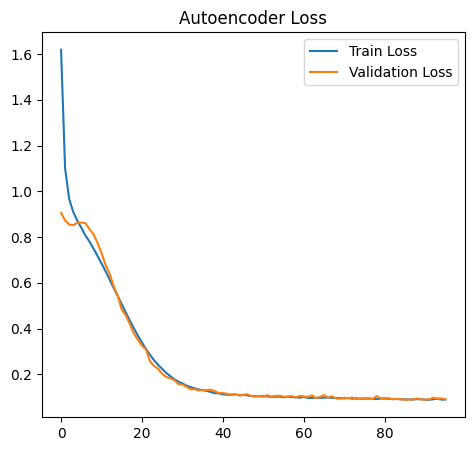

In [ ]:
import matplotlib.pyplot as plt

# Courbes d'apprentissage de l'autoencoder
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Autoencoder Loss')
plt.legend()

**Étape 3: Extraction des caractéristiques avec l'Autoencoder**

In [ ]:
# Extraction des caractéristiques latentes
# Get the encoder part of the autoencoder
encoder = Model(inputs=autoencoder.input, outputs=autoencoder.layers[-7].output) # This line was missing

X_train_encoded = encoder.predict(X_train)
X_test_encoded = encoder.predict(X_test)

# Reshape pour le CNN
X_train_encoded = X_train_encoded.reshape(X_train_encoded.shape[0], X_train_encoded.shape[1], 1)
X_test_encoded = X_test_encoded.reshape(X_test_encoded.shape[0], X_test_encoded.shape[1], 1)

print(f"Nouvelles formes pour CNN: {X_train_encoded.shape}")

50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Nouvelles formes pour CNN: (1580, 64, 1)


**Étape 4: Visualisation des résultats**

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense, Dropout, BatchNormalization, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.regularizers import l1_l2
import numpy as np

# 1. Architecture avancée du CNN
def build_advanced_cnn(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    # Branche 1 - Grands filtres pour motifs larges
    x1 = Conv1D(128, 15, activation='relu', padding='same', kernel_regularizer=l1_l2(0.001, 0.001))(inputs)
    x1 = BatchNormalization()(x1)
    x1 = MaxPooling1D(4)(x1)

    # Branche 2 - Filtres moyens
    x2 = Conv1D(128, 7, activation='relu', padding='same', kernel_regularizer=l1_l2(0.001, 0.001))(inputs)
    x2 = BatchNormalization()(x2)
    x2 = MaxPooling1D(4)(x2)

    # Branche 3 - Petits filtres pour détails locaux
    x3 = Conv1D(128, 3, activation='relu', padding='same', kernel_regularizer=l1_l2(0.001, 0.001))(inputs)
    x3 = BatchNormalization()(x3)
    x3 = MaxPooling1D(4)(x3)

    # Fusion des branches
    merged = concatenate([x1, x2, x3])
    x = Conv1D(256, 3, activation='relu')(merged)
    x = GlobalMaxPooling1D()(x)

    # Classificateur
    x = Dense(256, activation='relu', kernel_regularizer=l1_l2(0.001, 0.001))(x)
    x = Dropout(0.6)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    return Model(inputs, outputs)


# 2. Réglage des hyperparamètres
initial_learning_rate = 0.0005
optimizer = Adam(learning_rate=initial_learning_rate,
                # Choose either clipnorm OR clipvalue, not both
                clipnorm=1.0 #,  # Example: Using clipnorm
                #clipvalue=0.5
)
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                             factor=0.5,
                             patience=5,
                             min_lr=1e-7,
                             verbose=1)

# 3. Construction et compilation
cnn_model = build_advanced_cnn((X_train_cnn.shape[1], X_train_cnn.shape[2]), num_classes)
cnn_model.compile(optimizer=optimizer,
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

# 4. Entraînement avec validation croisée
history = cnn_model.fit(
    X_train_cnn, y_train,
    epochs=200,
    batch_size=64,  # Augmenté pour stabilité
    validation_data=(X_test_cnn, y_test),
    callbacks=[reduce_lr, EarlyStopping(patience=20, restore_best_weights=True)],
    verbose=1
)

# 5. Évaluation et analyse
test_loss, test_acc = cnn_model.evaluate(X_test_cnn, y_test, verbose=0)
print(f"\nPerformance finale: Accuracy = {test_acc*100:.2f}%")

# Matrice de confusion pour diagnostic
from sklearn.metrics import confusion_matrix, classification_report
y_pred = np.argmax(cnn_model.predict(X_test_cnn), axis=1)
y_true = np.argmax(y_test, axis=1)

print("\nMatrice de confusion:")
print(confusion_matrix(y_true, y_pred))
print("\nRapport de classification:")
print(classification_report(y_true, y_pred))

Epoch 1/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 15s 257ms/step - accuracy: 0.1230 - loss: 7.0575 - val_accuracy: 0.1392 - val_loss: 5.6849 - learning_rate: 5.0000e-04
Epoch 2/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.1325 - loss: 5.6874 - val_accuracy: 0.1392 - val_loss: 5.3381 - learning_rate: 5.0000e-04
Epoch 3/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.1510 - loss: 5.2522 - val_accuracy: 0.1468 - val_loss: 4.9528 - learning_rate: 5.0000e-04
Epoch 4/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.1782 - loss: 4.8696 - val_accuracy: 0.1671 - val_loss: 4.5948 - learning_rate: 5.0000e-04
Epoch 5/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.1461 - loss: 4.5059 - val_accuracy: 0.1671 - val_loss: 4.2766 - learning_rate: 5.0000e-04
Epoch 6/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.1817 - loss: 4.1871 - val_accuracy: 0.1899 - val_loss: 3.9971 - learning_rate: 5.0000e-04
Epoch 7/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.

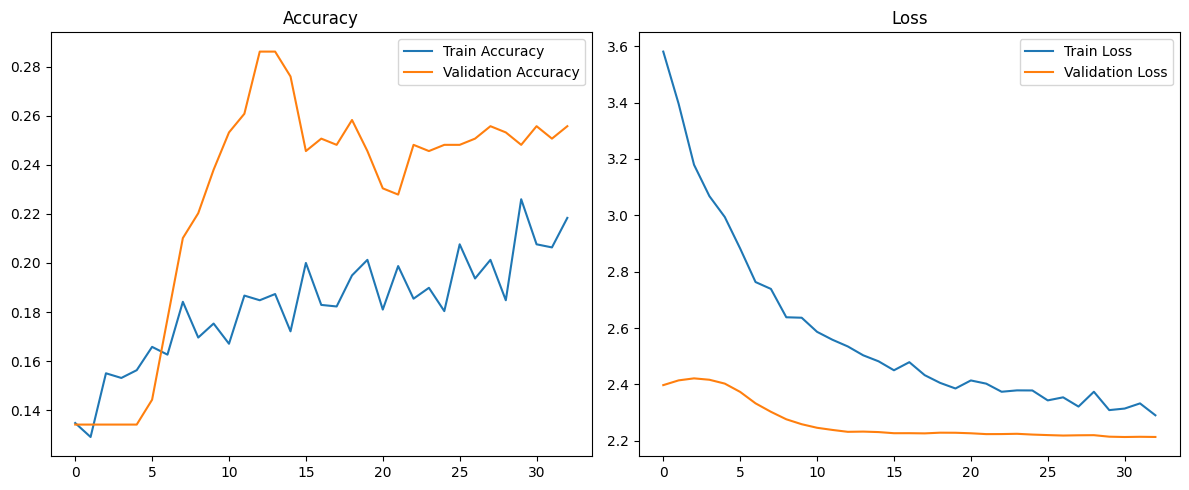

In [ ]:
# 8. Visualisation des résultats
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_cnn.history['accuracy'], label='Train Accuracy')
plt.plot(history_cnn.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_cnn.history['loss'], label='Train Loss')
plt.plot(history_cnn.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Conv1D, MaxPooling1D, Flatten, Dropout,
                                   BatchNormalization, Dense, Input, Add,
                                   Activation, AveragePooling1D)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

# 1. Vérification et nettoyage des données
print("Vérification des données:")
print("X_train_encoded contient NaN:", np.isnan(X_train_encoded).any())
print("X_train_encoded contient Inf:", np.isinf(X_train_encoded).any())
print("y_train contient NaN:", np.isnan(y_train).any())

X_train_encoded = np.nan_to_num(X_train_encoded, nan=0.0, posinf=1.0, neginf=-1.0)
X_test_encoded = np.nan_to_num(X_test_encoded, nan=0.0, posinf=1.0, neginf=-1.0)

# 2. Définition des blocs ResNet
def residual_block(x, filters, kernel_size=3, stride=1, conv_shortcut=True):
    """Bloc résiduel pour ResNet 1D"""
    if conv_shortcut:
        shortcut = Conv1D(filters, 1, strides=stride, padding='same')(x)
        shortcut = BatchNormalization()(shortcut)
    else:
        shortcut = x

    # Première couche convolutive
    x = Conv1D(filters, kernel_size, strides=stride, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('tanh')(x)

    # Deuxième couche convolutive
    x = Conv1D(filters, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)

    # Ajout de la connexion résiduelle
    x = Add()([x, shortcut])
    x = Activation('tanh')(x)
    return x

# 3. Construction du modèle ResNet
def build_resnet(input_shape, num_classes):
    """Construit un modèle ResNet simplifié pour les données 1D"""
    inputs = Input(shape=input_shape)

    # Couche initiale
    x = Conv1D(64, 7, strides=2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('tanh')(x)
    x = MaxPooling1D(3, strides=2, padding='same')(x)

    # Blocs résiduels
    x = residual_block(x, 64, conv_shortcut=False)
    x = residual_block(x, 64)
    x = residual_block(x, 64)

    x = residual_block(x, 128, stride=2)
    x = residual_block(x, 128)
    x = residual_block(x, 128)

    x = residual_block(x, 256, stride=2)
    x = residual_block(x, 256)
    x = residual_block(x, 256)

    # Couches finales
    x = AveragePooling1D(pool_size=2)(x)
    x = Flatten()(x)
    x = Dense(256, activation='tanh', kernel_regularizer=l2(0.001))(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    return Model(inputs, outputs)

# 4. Création et compilation du modèle
model = build_resnet((X_train_encoded.shape[1], 1), num_classes)

optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer,
             loss='categorical_crossentropy',
             metrics=['accuracy'])

model.summary()

# 5. Callback et entraînement
early_stopping = EarlyStopping(monitor='val_loss',
                             patience=15,
                             restore_best_weights=True,
                             min_delta=0.0001)

try:
    history = model.fit(
        X_train_encoded, y_train,
        epochs=150,
        batch_size=64,
        validation_data=(X_test_encoded, y_test),
        callbacks=[early_stopping],
        verbose=1
    )

    # Évaluation
    loss, accuracy = model.evaluate(X_test_encoded, y_test)
    print(f"Accuracy finale: {accuracy*100:.2f}%")

except Exception as e:
    print(f"Erreur pendant l'entraînement: {str(e)}")
    print("Solutions supplémentaires à essayer:")
    print("- Vérifiez que vos données ont une dimension temporelle suffisante")
    print("- Essayez de réduire la profondeur du réseau (moins de blocs résiduels)")
    print("- Normalisez vos données entre -1 et 1 (pour l'activation tanh)")

Vérification des données:
X_train_encoded contient NaN: False
X_train_encoded contient Inf: False
y_train contient NaN: False


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 64, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_7 (Conv1D)   │ (None, 32, 64)    │        512 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 64)    │        256 │ conv1d_7[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 32, 64)    │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_6     │ (None, 16, 64)    │          0 │ activation[0][0]  │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_8 (Conv1D)   │ (None, 16, 64)    │     12,352 │ max_pooling1d_6[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 64)    │        256 │ conv1d_8[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 16, 64)    │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_9 (Conv1D)   │ (None, 16, 64)    │     12,352 │ activation_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 64)    │        256 │ conv1d_9[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 16, 64)    │          0 │ batch_normalizat… │
│                     │                   │            │ max_pooling1d_6[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 16, 64)    │          0 │ add[0][0]         │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_11 (Conv1D)  │ (None, 16, 64)    │     12,352 │ activation_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 64)    │        256 │ conv1d_11[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 16, 64)    │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_12 (Conv1D)  │ (None, 16, 64)    │     12,352 │ activation_3[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_10 (Conv1D)  │ (None, 16, 64)    │      4,160 │ activation_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 64)    │        256 │ conv1d_12[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 64)    │        256 │ conv1d_10[0][0] 

 Total params: 1,792,392 (6.84 MB)

 Trainable params: 1,784,328 (6.81 MB)

 Non-trainable params: 8,064 (31.50 KB)

Epoch 1/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 44s 599ms/step - accuracy: 0.1820 - loss: 2.5848 - val_accuracy: 0.2380 - val_loss: 2.3747
Epoch 2/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 16s 21ms/step - accuracy: 0.3153 - loss: 2.1377 - val_accuracy: 0.2278 - val_loss: 2.3229
Epoch 3/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.3796 - loss: 2.0138 - val_accuracy: 0.2253 - val_loss: 2.3093
Epoch 4/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4336 - loss: 1.9078 - val_accuracy: 0.2354 - val_loss: 2.3457
Epoch 5/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4498 - loss: 1.7999 - val_accuracy: 0.2253 - val_loss: 2.3535
Epoch 6/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5071 - loss: 1.6976 - val_accuracy: 0.2177 - val_loss: 2.4206
Epoch 7/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5122 - loss: 1.6902 - val_accuracy: 0.2076 - val_loss: 2.4396
Epoch 8/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5219 - loss: 1.6311 - val_accuracy:

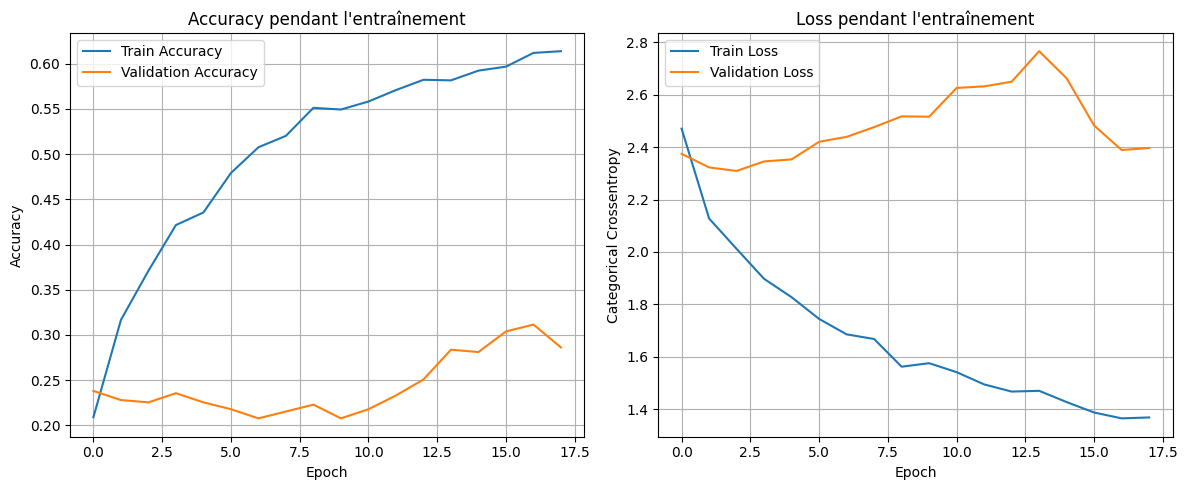

13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 143ms/step


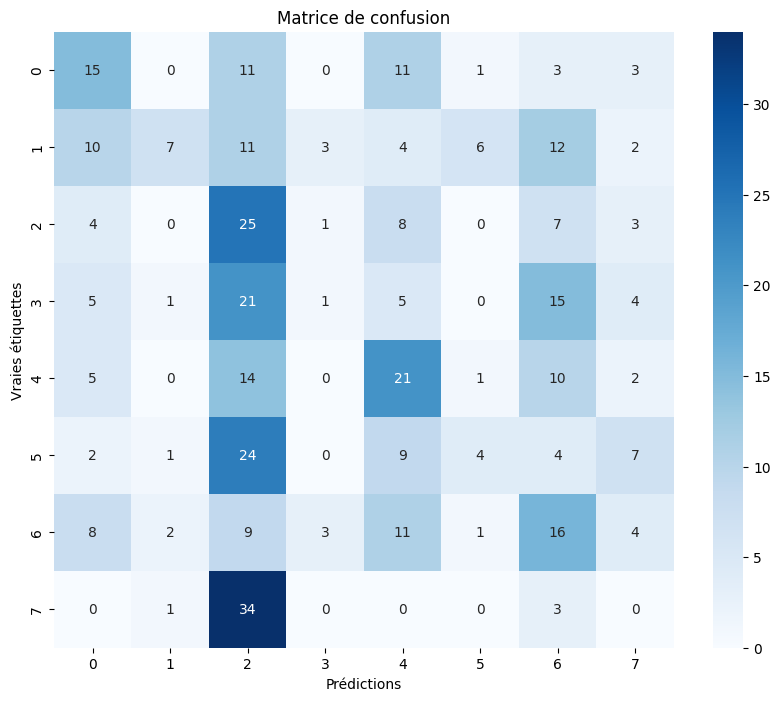


Rapport de classification:
              precision    recall  f1-score   support

    Classe 0       0.31      0.34      0.32        44
    Classe 1       0.58      0.13      0.21        55
    Classe 2       0.17      0.52      0.25        48
    Classe 3       0.12      0.02      0.03        52
    Classe 4       0.30      0.40      0.34        53
    Classe 5       0.31      0.08      0.12        51
    Classe 6       0.23      0.30      0.26        54
    Classe 7       0.00      0.00      0.00        38

    accuracy                           0.23       395
   macro avg       0.25      0.22      0.19       395
weighted avg       0.26      0.23      0.20       395



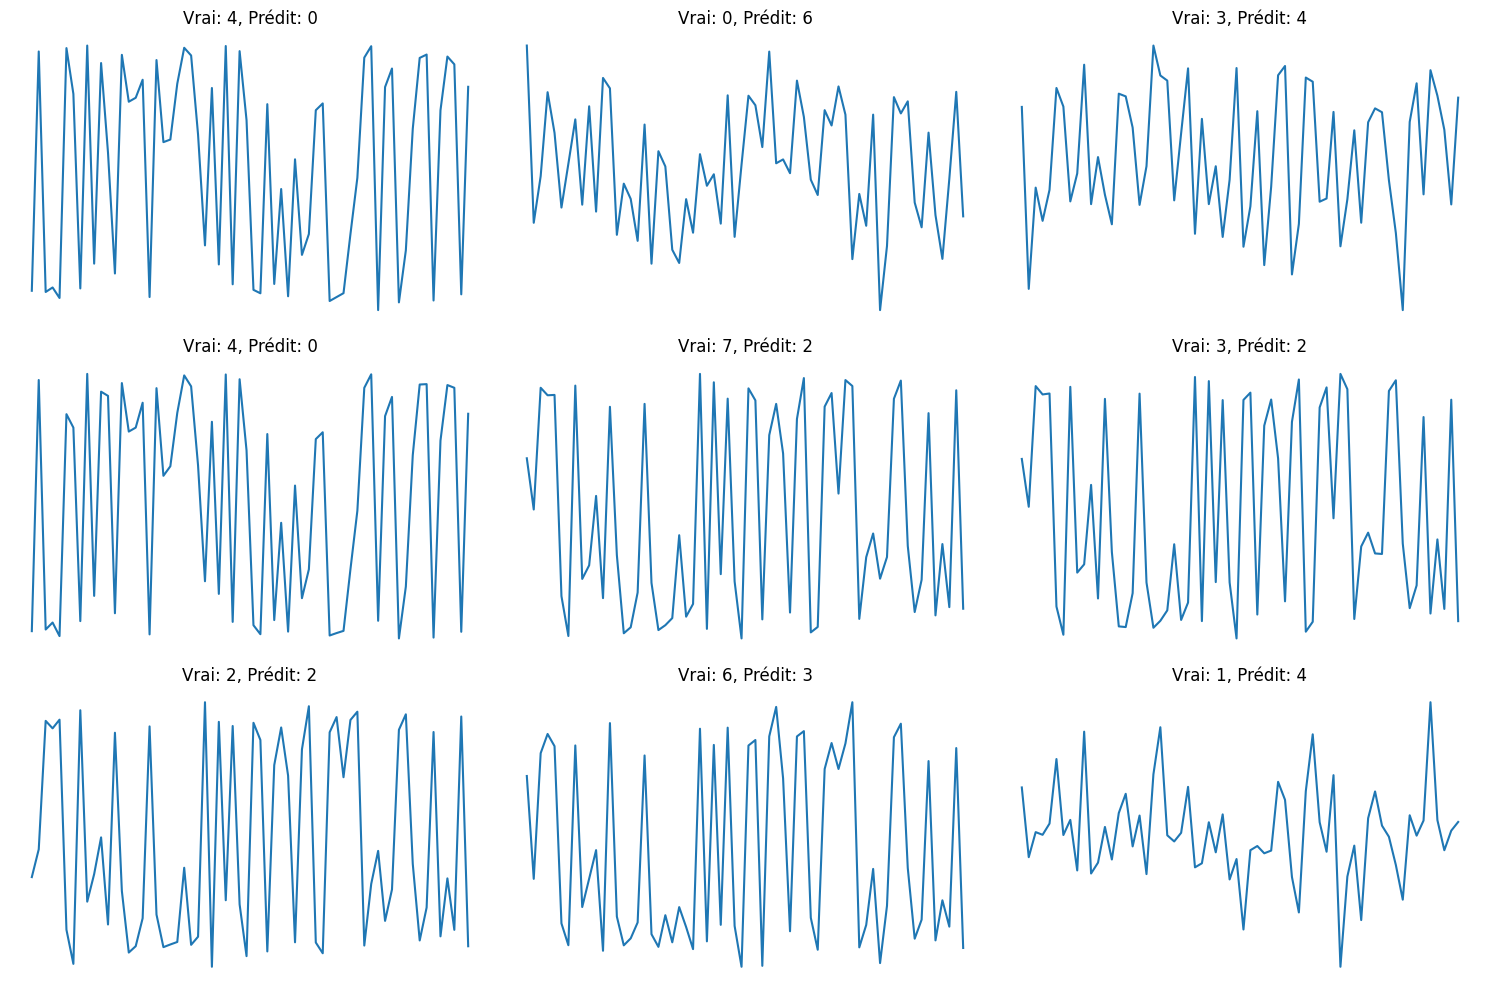

<ipython-input-32-b04d7830b85f>:73: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(class_probs, label=f'Classe {class_id}', shade=True)
<ipython-input-32-b04d7830b85f>:73: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(class_probs, label=f'Classe {class_id}', shade=True)
<ipython-input-32-b04d7830b85f>:73: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(class_probs, label=f'Classe {class_id}', shade=True)
<ipython-input-32-b04d7830b85f>:73: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(class_probs, labe

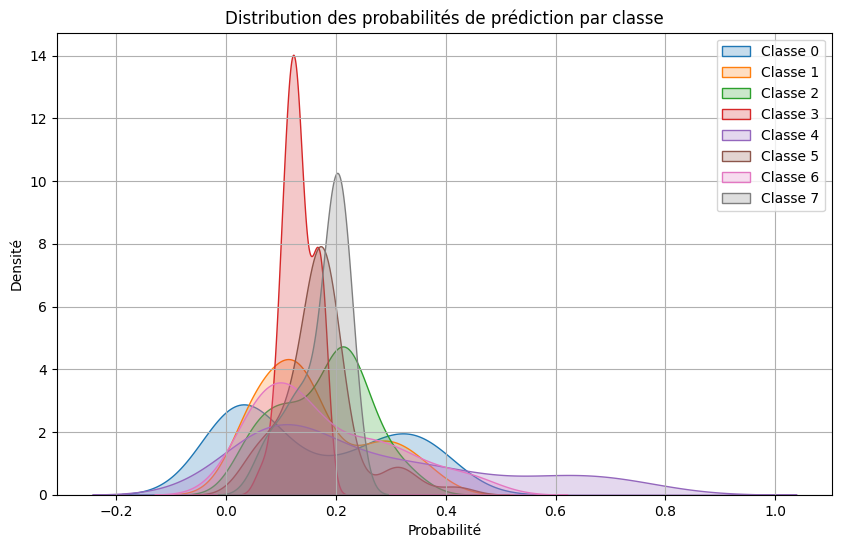


Taux d'erreur: 77.47%
Exemples d'erreurs:


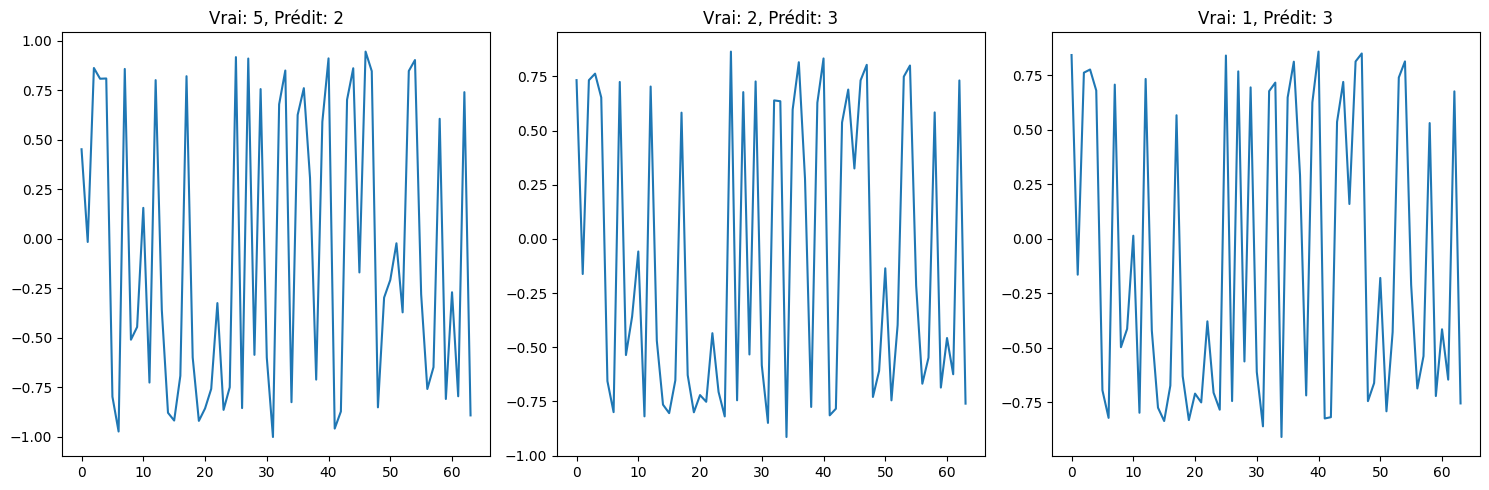

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.utils import to_categorical

# 1. Courbes d'apprentissage
plt.figure(figsize=(12, 5))

# Courbe de précision
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy pendant l\'entraînement')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)

# Courbe de loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss pendant l\'entraînement')
plt.ylabel('Categorical Crossentropy')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# 2. Matrice de confusion
y_pred = model.predict(X_test_encoded)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1) if len(y_test.shape) > 1 else y_test

cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(y_true),
            yticklabels=np.unique(y_true))
plt.title('Matrice de confusion')
plt.ylabel('Vraies étiquettes')
plt.xlabel('Prédictions')
plt.show()

# 3. Rapport de classification
print("\nRapport de classification:")
print(classification_report(y_true, y_pred_classes,
                           target_names=[f"Classe {i}" for i in np.unique(y_true)]))

# 4. Visualisation des prédictions (exemples aléatoires)
plt.figure(figsize=(15, 10))
for i in range(9):
    idx = np.random.randint(0, len(X_test_encoded))
    sample = X_test_encoded[idx]
    true_label = y_true[idx]
    pred_label = y_pred_classes[idx]

    plt.subplot(3, 3, i+1)
    plt.plot(sample)
    plt.title(f"Vrai: {true_label}, Prédit: {pred_label}")
    plt.axis('off')

plt.tight_layout()
plt.show()

# 5. Distribution des probabilités de prédiction
plt.figure(figsize=(10, 6))
for class_id in np.unique(y_true):
    class_probs = y_pred[y_true == class_id][:, class_id]
    sns.kdeplot(class_probs, label=f'Classe {class_id}', shade=True)

plt.title('Distribution des probabilités de prédiction par classe')
plt.xlabel('Probabilité')
plt.ylabel('Densité')
plt.legend()
plt.grid(True)
plt.show()

# 6. Analyse des erreurs
errors = (y_pred_classes != y_true)
error_samples = X_test_encoded[errors]
error_true = y_true[errors]
error_pred = y_pred_classes[errors]

print(f"\nTaux d'erreur: {100*len(error_samples)/len(X_test_encoded):.2f}%")
print("Exemples d'erreurs:")

plt.figure(figsize=(15, 5))
for i in range(min(3, len(error_samples))):
    plt.subplot(1, 3, i+1)
    plt.plot(error_samples[i])
    plt.title(f"Vrai: {error_true[i]}, Prédit: {error_pred[i]}")
plt.tight_layout()
plt.show()